In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
# from wordcloud import WordCloud
from IPython.display import display
import base64
import string
import re
from collections import Counter
from time import time
# from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS as stopwords
from nltk.corpus import stopwords
from sklearn.metrics import log_loss
import language_check
import spacy

from skll.metrics import kappa
from scipy.sparse import csr_matrix

nlp = spacy.load('en')

stopwords = stopwords.words('english')

sns.set_context('notebook')
print('Numpy version:', np.__version__)
print('Pandas version:', pd.__version__)
print('Seaborn version:', sns.__version__)

Numpy version: 1.14.3
Pandas version: 0.23.2
Seaborn version: 0.8.1


In [2]:
def correct_language(df, logging=False):
    """
    use language tool to correct for most spelling and grammatical errors. Also count the applied corrections. 
    Using language_check python wrapper for languagetool:
    https://www.languagetool.org/dev
    """
    tool = language_check.LanguageTool('en-US')
    counter = 1

    df['matches'] = df['essay'].apply(lambda txt: tool.check(txt))
    df['corrections'] = df.apply(lambda l: len(l['matches']), axis=1)
    df['corrected'] = df.apply(lambda l: language_check.correct(l['essay'], l['matches']), axis=1)
      
    return df

In [3]:
# read essays from training_set
training_set  = pd.read_csv('training_set_rel3.tsv', sep='\t', encoding = "ISO-8859-1")\
            .rename(columns={'essay_set': 'topic', 'domain1_score': 'target_score', 'domain2_score': 'topic2_target'})

# apply spelling and grammar corrections
training_set = correct_language(training_set)

training_set.head()

,essay_id,topic,essay,rater1_domain1,rater2_domain1,rater3_domain1,target_score,rater1_domain2,rater2_domain2,topic2_target,...,rater2_trait6,rater3_trait1,rater3_trait2,rater3_trait3,rater3_trait4,rater3_trait5,rater3_trait6,matches,corrections,corrected
0,1,1,"Dear local newspaper, I think effects computer...",4,4,NaN,8,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[Line 1, column 219, Rule ID: MORFOLOGIK_RULE_...",11,"Dear local newspaper, I think effects computer..."
1,2,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",5,4,NaN,9,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[Line 1, column 149, Rule ID: MORFOLOGIK_RULE_...",19,"Dear @CAPS1 @CAPS2, I believe that using compu..."
2,3,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",4,3,NaN,7,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[Line 1, column 316, Rule ID: MORFOLOGIK_RULE_...",9,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl..."
3,4,1,"Dear Local Newspaper, @CAPS1 I have found that...",5,5,NaN,10,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[Line 1, column 87, Rule ID: MORFOLOGIK_RULE_E...",35,"Dear Local Newspaper, @CAPS1 I have found that..."
4,5,1,"Dear @LOCATION1, I know having computers has a...",4,4,NaN,8,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[Line 1, column 178, Rule ID: MORFOLOGIK_RULE_...",17,"Dear @LOCATION1, I know having computers has a..."


In [2]:
training_set = pd.read_pickle('training_features.pkl')

In [127]:
test = training_set

In [128]:
# Clean text before feeding it to spaCy
punctuations = string.punctuation

# Define function to cleanup text by removing personal pronouns, stopwords, and puncuation
def cleanup_text(docs, logging=False):
    texts = []
    counter = 1
    for doc in docs.corrected:
        if counter % 200 == 0 and logging:
            print("Processed %d out of %d documents." % (counter, len(docs)))
        counter += 1
        doc = nlp(doc, disable=['parser', 'ner'])
        tokens = [tok.lemma_.lower().strip() for tok in doc if tok.lemma_ != '-PRON-']
        tokens = [tok for tok in tokens if tok not in stopwords and tok not in punctuations]
        tokens = ' '.join(tokens)
        texts.append(tokens)
    return pd.Series(texts)

In [129]:
# Cleanup text and make sure it retains original shape
print('Original training data shape: ', test['corrected'].shape)
train_cleaned = cleanup_text(test, logging=True)
print('Cleaned up training data shape: ', train_cleaned.shape)

Original training data shape:  (12976,)
Processed 200 out of 12976 documents.
Processed 400 out of 12976 documents.
Processed 600 out of 12976 documents.
Processed 800 out of 12976 documents.
Processed 1000 out of 12976 documents.
Processed 1200 out of 12976 documents.
Processed 1400 out of 12976 documents.
Processed 1600 out of 12976 documents.
Processed 1800 out of 12976 documents.
Processed 2000 out of 12976 documents.
Processed 2200 out of 12976 documents.
Processed 2400 out of 12976 documents.
Processed 2600 out of 12976 documents.
Processed 2800 out of 12976 documents.
Processed 3000 out of 12976 documents.
Processed 3200 out of 12976 documents.
Processed 3400 out of 12976 documents.
Processed 3600 out of 12976 documents.
Processed 3800 out of 12976 documents.
Processed 4000 out of 12976 documents.
Processed 4200 out of 12976 documents.
Processed 4400 out of 12976 documents.
Processed 4600 out of 12976 documents.
Processed 4800 out of 12976 documents.
Processed 5000 out of 12976 

In [130]:
# Define function to preprocess text for a word2vec model
def cleanup_text_word2vec(docs, logging=False):
    sentences = []
    counter = 1
    for doc in docs:
        if counter % 200 == 0 and logging:
            print("Processed %d out of %d documents" % (counter, len(docs)))
        # Disable tagger so that lemma_ of personal pronouns (I, me, etc) don't getted marked as "-PRON-"
        doc = nlp(doc, disable=['tagger'])
        # Grab lemmatized form of words and make lowercase
        doc = " ".join([tok.lemma_.lower() for tok in doc])
        # Split into sentences based on punctuation
        doc = re.split("[\.?!;] ", doc)
        # Remove commas, periods, and other punctuation (mostly commas)
        doc = [re.sub("[\.,;:!?]", "", sent) for sent in doc]
        # Split into words
        doc = [sent.split() for sent in doc]
        sentences += doc
        counter += 1
    return sentences

In [131]:
train_cleaned_word2vec = cleanup_text_word2vec(test['corrected'], logging=True)
print('Cleaned up training data size (i.e. number of sentences): ', len(train_cleaned_word2vec))

Processed 200 out of 12976 documents
Processed 400 out of 12976 documents
Processed 600 out of 12976 documents
Processed 800 out of 12976 documents
Processed 1000 out of 12976 documents
Processed 1200 out of 12976 documents
Processed 1400 out of 12976 documents
Processed 1600 out of 12976 documents
Processed 1800 out of 12976 documents
Processed 2000 out of 12976 documents
Processed 2200 out of 12976 documents
Processed 2400 out of 12976 documents
Processed 2600 out of 12976 documents
Processed 2800 out of 12976 documents
Processed 3000 out of 12976 documents
Processed 3200 out of 12976 documents
Processed 3400 out of 12976 documents
Processed 3600 out of 12976 documents
Processed 3800 out of 12976 documents
Processed 4000 out of 12976 documents
Processed 4200 out of 12976 documents
Processed 4400 out of 12976 documents
Processed 4600 out of 12976 documents
Processed 4800 out of 12976 documents
Processed 5000 out of 12976 documents
Processed 5200 out of 12976 documents
Processed 5400 o

In [132]:
from gensim.models.word2vec import Word2Vec

text_dim = 300
print("Training Word2Vec model...")
wordvec_model = Word2Vec(train_cleaned_word2vec, size=text_dim, window=5, min_count=3, workers=4, sg=1)
print("Word2Vec model created.")
print("%d unique words represented by %d dimensional vectors" % (len(wordvec_model.wv.vocab), text_dim))

Training Word2Vec model...
Word2Vec model created.
8440 unique words represented by 300 dimensional vectors


In [133]:
# Define function to create word vectors given a cleaned piece of text.
def create_average_vec(doc):
    average = np.zeros((text_dim,), dtype='float32')
    num_words = 0.
    for word in doc.split():
        if word in wordvec_model.wv.vocab:
            average = np.add(average, wordvec_model.wv[word])
            num_words += 1.
    if num_words != 0.:
        average = np.divide(average, num_words)
    return average

In [134]:
# Create word vectors
train_cleaned_vec = np.zeros((test.shape[0], text_dim), dtype="float32")  # 19579 x 300
for i in range(len(train_cleaned)):
    train_cleaned_vec[i] = create_average_vec(train_cleaned[i])

print("Train word vector shape:", train_cleaned_vec.shape)

Train word vector shape: (12976, 300)


In [27]:
y = pd.get_dummies(test.target_score)
y.shape

(1770, 4)

In [135]:
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
scaler = MinMaxScaler((0,60))
ohe = OneHotEncoder(n_values=61)

original_scores = test.target_score.to_frame()
y_scaled = scaler.fit_transform(pd.DataFrame(original_scores))
# y = pd.get_dummies(test.target_score)
# y.shape
y = ohe.fit_transform(y_scaled)
y

<12976x61 sparse matrix of type '<class 'numpy.float64'>'
	with 12976 stored elements in Compressed Sparse Row format>

In [136]:
from sklearn.model_selection import train_test_split

# If using spaCy word vectors
# X_train, X_test, y_train, y_test = train_test_split(train_vec, y_train_ohe, test_size=0.2, random_state=26)
# If using Word2Vec word vectors
X_train, X_test, y_train, y_test = train_test_split(train_cleaned_vec, y, test_size=0.2, random_state=26)
X = train_cleaned_vec

print('X_train size: {}'.format(X_train.shape))
print('X_test size: {}'.format(X_test.shape))
print('y_train size: {}'.format(y_train.shape))
print('y_test size: {}'.format(y_test.shape))

X_train size: (10380, 300)
X_test size: (2596, 300)
y_train size: (10380, 61)
y_test size: (2596, 61)


In [137]:
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Input, LSTM, Embedding, Bidirectional, Flatten
from keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D
from keras.optimizers import SGD, Adam

unique_scores = 61 #len(test.target_score.unique())
input_dim = 300
dropout = 0.2

def build_model(architecture='mlp'):
    model = Sequential()
    if architecture == 'mlp':
        # Densely Connected Neural Network (Multi-Layer Perceptron)
        model.add(Dense(512, activation='relu', kernel_initializer='he_normal', input_dim=input_dim)) 
        model.add(Dropout(dropout))
        model.add(Dense(512, activation='relu', kernel_initializer='he_normal'))
        model.add(Dropout(dropout))
        model.add(Dense(unique_scores, activation='softmax'))
    elif architecture == 'cnn':
        # 1-D Convolutional Neural Network
        inputs = Input(shape=(input_dim,1))

        x = Conv1D(64, 3, strides=1, padding='same', activation='relu')(inputs)

        #Cuts the size of the output in half, maxing over every 2 inputs
        x = MaxPooling1D(pool_size=2)(x)
        x = Conv1D(128, 3, strides=1, padding='same', activation='relu')(x)
        x = GlobalMaxPooling1D()(x) 
        outputs = Dense(unique_scores, activation='softmax')(x)

        model = Model(inputs=inputs, outputs=outputs, name='CNN')
    elif architecture == 'lstm':
        # LSTM network
        inputs = Input(shape=(input_dim,1))

        x = Bidirectional(LSTM(64, return_sequences=True),
                          merge_mode='concat')(inputs)
        x = Dropout(dropout)(x)
        x = Flatten()(x)
        outputs = Dense(unique_scores, activation='softmax')(x)

        model = Model(inputs=inputs, outputs=outputs, name='LSTM')
    else:
        print('Error: Model type not found.')
    return model

In [138]:
# Define keras model
# Using MLP in kernel for speed
model = build_model('mlp')
# model = build_model('cnn')
# model = build_model('lstm')

# If the model is a CNN then expand the dimensions of the training data
if model.name == "CNN" or model.name == "LSTM":
    X_train = np.expand_dims(X_train, axis=2)
    X_test = np.expand_dims(X_test, axis=2)
    print('Text train shape: ', X_train.shape)
    print('Text test shape: ', X_test.shape)
    
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 512)               154112    
_________________________________________________________________
dropout_13 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_14 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 61)                31293     
Total params: 448,061
Trainable params: 448,061
Non-trainable params: 0
_________________________________________________________________


In [139]:
# Compile the model
# sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
adam = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['acc'])

# Define number of epochs
epochs = 50

# Fit the model to the training data
estimator = model.fit(X_train, y_train,
                      validation_split=0.3,
                      epochs=epochs, batch_size=128, verbose=1)

Train on 7265 samples, validate on 3115 samples
Epoch 1/50
7265/7265 [==============================] - ETA: 23s - loss: 4.1963 - acc: 0.0000e+ - ETA: 4s - loss: 4.1512 - acc: 0.0078     - ETA: 2s - loss: 4.1131 - acc: 0.037 - ETA: 2s - loss: 4.0717 - acc: 0.073 - ETA: 1s - loss: 4.0373 - acc: 0.091 - ETA: 1s - loss: 4.0077 - acc: 0.107 - ETA: 1s - loss: 3.9672 - acc: 0.121 - ETA: 0s - loss: 3.9228 - acc: 0.137 - ETA: 0s - loss: 3.8838 - acc: 0.141 - ETA: 0s - loss: 3.8479 - acc: 0.145 - ETA: 0s - loss: 3.8158 - acc: 0.151 - ETA: 0s - loss: 3.7660 - acc: 0.156 - ETA: 0s - loss: 3.7290 - acc: 0.158 - ETA: 0s - loss: 3.6773 - acc: 0.161 - ETA: 0s - loss: 3.6252 - acc: 0.166 - ETA: 0s - loss: 3.5888 - acc: 0.168 - 1s 196us/step - loss: 3.5780 - acc: 0.1686 - val_loss: 2.8206 - val_acc: 0.2254
Epoch 2/50
7265/7265 [==============================] - ETA: 1s - loss: 2.7605 - acc: 0.257 - ETA: 0s - loss: 2.8171 - acc: 0.207 - ETA: 0s - loss: 2.7517 - acc: 0.226 - ETA: 0s - loss: 2.7233 - acc:

7265/7265 [==============================] - ETA: 1s - loss: 1.5733 - acc: 0.398 - ETA: 0s - loss: 1.6426 - acc: 0.416 - ETA: 0s - loss: 1.6487 - acc: 0.417 - ETA: 0s - loss: 1.6930 - acc: 0.406 - ETA: 0s - loss: 1.6777 - acc: 0.404 - ETA: 0s - loss: 1.6805 - acc: 0.401 - ETA: 0s - loss: 1.6910 - acc: 0.395 - ETA: 0s - loss: 1.6892 - acc: 0.396 - ETA: 0s - loss: 1.6875 - acc: 0.396 - ETA: 0s - loss: 1.6864 - acc: 0.395 - ETA: 0s - loss: 1.6973 - acc: 0.389 - ETA: 0s - loss: 1.6991 - acc: 0.388 - ETA: 0s - loss: 1.7035 - acc: 0.388 - ETA: 0s - loss: 1.7047 - acc: 0.387 - ETA: 0s - loss: 1.7061 - acc: 0.384 - ETA: 0s - loss: 1.6959 - acc: 0.386 - ETA: 0s - loss: 1.6962 - acc: 0.385 - 1s 141us/step - loss: 1.6959 - acc: 0.3851 - val_loss: 1.6987 - val_acc: 0.4010
Epoch 12/50
7265/7265 [==============================] - ETA: 1s - loss: 1.7050 - acc: 0.445 - ETA: 0s - loss: 1.6853 - acc: 0.394 - ETA: 0s - loss: 1.6932 - acc: 0.401 - ETA: 0s - loss: 1.6809 - acc: 0.392 - ETA: 0s - loss: 1.67

7265/7265 [==============================] - ETA: 1s - loss: 1.5092 - acc: 0.406 - ETA: 1s - loss: 1.5350 - acc: 0.414 - ETA: 0s - loss: 1.5057 - acc: 0.429 - ETA: 0s - loss: 1.5382 - acc: 0.424 - ETA: 0s - loss: 1.5409 - acc: 0.423 - ETA: 0s - loss: 1.5477 - acc: 0.418 - ETA: 0s - loss: 1.5748 - acc: 0.413 - ETA: 0s - loss: 1.5822 - acc: 0.412 - ETA: 0s - loss: 1.5790 - acc: 0.416 - ETA: 0s - loss: 1.5717 - acc: 0.419 - ETA: 0s - loss: 1.5731 - acc: 0.416 - ETA: 0s - loss: 1.5687 - acc: 0.420 - ETA: 0s - loss: 1.5663 - acc: 0.421 - ETA: 0s - loss: 1.5657 - acc: 0.422 - ETA: 0s - loss: 1.5665 - acc: 0.421 - ETA: 0s - loss: 1.5683 - acc: 0.421 - ETA: 0s - loss: 1.5646 - acc: 0.422 - 1s 145us/step - loss: 1.5647 - acc: 0.4217 - val_loss: 1.5884 - val_acc: 0.4215
Epoch 22/50
7265/7265 [==============================] - ETA: 1s - loss: 1.5583 - acc: 0.476 - ETA: 0s - loss: 1.5042 - acc: 0.464 - ETA: 0s - loss: 1.5451 - acc: 0.443 - ETA: 0s - loss: 1.5505 - acc: 0.436 - ETA: 0s - loss: 1.56

7265/7265 [==============================] - ETA: 1s - loss: 1.5447 - acc: 0.445 - ETA: 0s - loss: 1.4844 - acc: 0.451 - ETA: 0s - loss: 1.4559 - acc: 0.464 - ETA: 0s - loss: 1.4477 - acc: 0.462 - ETA: 0s - loss: 1.4665 - acc: 0.456 - ETA: 0s - loss: 1.4635 - acc: 0.455 - ETA: 0s - loss: 1.4693 - acc: 0.454 - ETA: 0s - loss: 1.4650 - acc: 0.455 - ETA: 0s - loss: 1.4681 - acc: 0.450 - ETA: 0s - loss: 1.4605 - acc: 0.453 - ETA: 0s - loss: 1.4636 - acc: 0.452 - ETA: 0s - loss: 1.4656 - acc: 0.454 - ETA: 0s - loss: 1.4674 - acc: 0.452 - ETA: 0s - loss: 1.4696 - acc: 0.452 - ETA: 0s - loss: 1.4731 - acc: 0.451 - 1s 131us/step - loss: 1.4725 - acc: 0.4513 - val_loss: 1.5229 - val_acc: 0.4347
Epoch 33/50
7265/7265 [==============================] - ETA: 1s - loss: 1.5338 - acc: 0.484 - ETA: 0s - loss: 1.5100 - acc: 0.454 - ETA: 0s - loss: 1.4929 - acc: 0.457 - ETA: 0s - loss: 1.4650 - acc: 0.466 - ETA: 0s - loss: 1.4715 - acc: 0.462 - ETA: 0s - loss: 1.4654 - acc: 0.462 - ETA: 0s - loss: 1.46

7265/7265 [==============================] - ETA: 1s - loss: 1.5246 - acc: 0.468 - ETA: 0s - loss: 1.4281 - acc: 0.453 - ETA: 0s - loss: 1.4529 - acc: 0.447 - ETA: 0s - loss: 1.4433 - acc: 0.444 - ETA: 0s - loss: 1.4219 - acc: 0.454 - ETA: 0s - loss: 1.4203 - acc: 0.457 - ETA: 0s - loss: 1.4072 - acc: 0.464 - ETA: 0s - loss: 1.4129 - acc: 0.462 - ETA: 0s - loss: 1.4235 - acc: 0.460 - ETA: 0s - loss: 1.4173 - acc: 0.463 - ETA: 0s - loss: 1.4225 - acc: 0.463 - ETA: 0s - loss: 1.4175 - acc: 0.465 - ETA: 0s - loss: 1.4086 - acc: 0.469 - ETA: 0s - loss: 1.4122 - acc: 0.468 - ETA: 0s - loss: 1.4105 - acc: 0.470 - 1s 132us/step - loss: 1.4123 - acc: 0.4709 - val_loss: 1.4835 - val_acc: 0.4462
Epoch 44/50
7265/7265 [==============================] - ETA: 1s - loss: 1.3842 - acc: 0.500 - ETA: 0s - loss: 1.3710 - acc: 0.490 - ETA: 0s - loss: 1.4115 - acc: 0.476 - ETA: 0s - loss: 1.3920 - acc: 0.471 - ETA: 0s - loss: 1.4060 - acc: 0.463 - ETA: 0s - loss: 1.4075 - acc: 0.466 - ETA: 0s - loss: 1.40

In [140]:
print("Training accuracy: %.2f%% / Validation accuracy: %.2f%%" % 
      (100*estimator.history['acc'][-1], 100*estimator.history['val_acc'][-1]))

# Calculate kappa metric
y_proba = model.predict(X_test)
y_pred = y_proba.argmax(axis=-1)
y_t = csr_matrix.argmax(y_test, axis=1)
y_t = np.squeeze(np.asarray(y_t))
# y_t = y_test.idxmax(axis=1)
k_qw = kappa(y_pred, y_t, weights='quadratic')
print("Kappa score: {:.2f}%".format(k_qw * 100))

Training accuracy: 47.87% / Validation accuracy: 44.91%
Kappa score: 93.81%


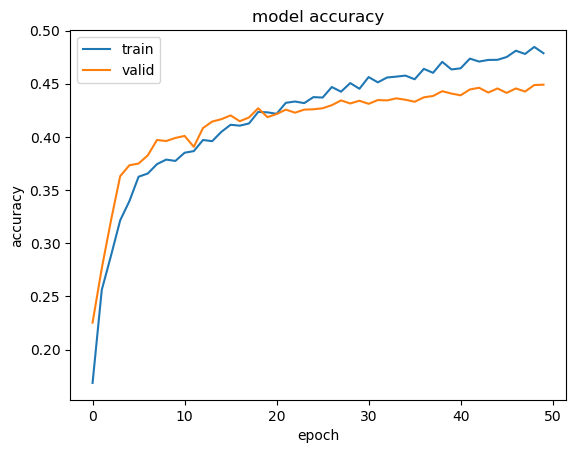

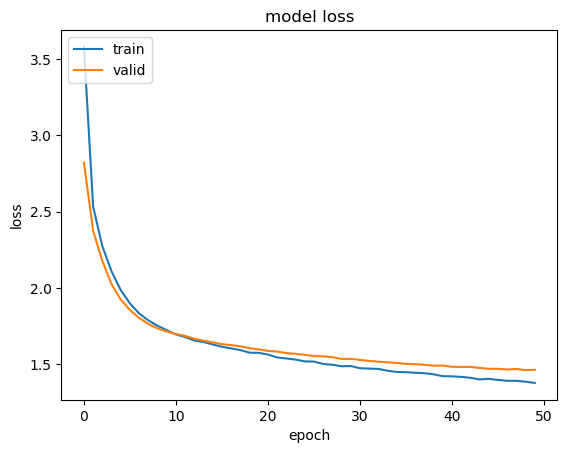

In [141]:
# Plot model accuracy over epochs
sns.reset_orig()   # Reset seaborn settings to get rid of black background
plt.plot(estimator.history['acc'])
plt.plot(estimator.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

# Plot model loss over epochs
plt.plot(estimator.history['loss'])
plt.plot(estimator.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()